In [24]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import pickle
import itertools
from datetime import datetime
import alphalens
from alphalens.performance import mean_information_coefficient

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

In [3]:
Prices = pickle.load(open('Prices.pkl', 'rb'))

In [4]:
train_start = datetime(2016, 1, 1)
train_end = datetime(2017, 12, 31)

trainPrices = {}
for symbol, data in Prices.items():
    trainPrices[symbol] = data.loc[train_start:train_end]

In [127]:
whl = trainPrices['WHL.JO'].copy()
whl

high      low     open    close     volume    adj_close
Date                                                                  
2016-01-01  10015.0  10015.0  10015.0  10015.0        0.0  8272.963867
2016-01-04   9889.0   9571.0   9760.0   9605.0  1972991.0  7934.280273
2016-01-05   9912.0   9550.0   9630.0   9880.0  2359678.0  8161.446777
2016-01-06   9920.0   9645.0   9788.0   9788.0  2946740.0  8085.449219
2016-01-07   9763.0   9120.0   9600.0   9660.0  5489329.0  7979.713867
...             ...      ...      ...      ...        ...          ...
2017-12-25   6293.0   6293.0   6293.0   6293.0        0.0  5665.954102
2017-12-26   6293.0   6293.0   6293.0   6293.0        0.0  5665.954102
2017-12-27   6360.0   6242.0   6290.0   6329.0  3542933.0  5698.367188
2017-12-28   6447.0   6300.0   6320.0   6447.0  2857012.0  5804.608887
2017-12-29   6535.0   6370.0   6400.0   6515.0    73001.0  5865.833496

[517 rows x 6 columns]

In [128]:
ema26 = ta.ema(whl['close'], length = 26)
ema12 = ta.ema(whl['close'], length = 12)

whl['ema26'] = ema26
whl['ema12'] = ema12

whl['macd'] = ema12 - ema26
whl['macd_signal_line'] = ta.ema(whl['macd'], length = 9)

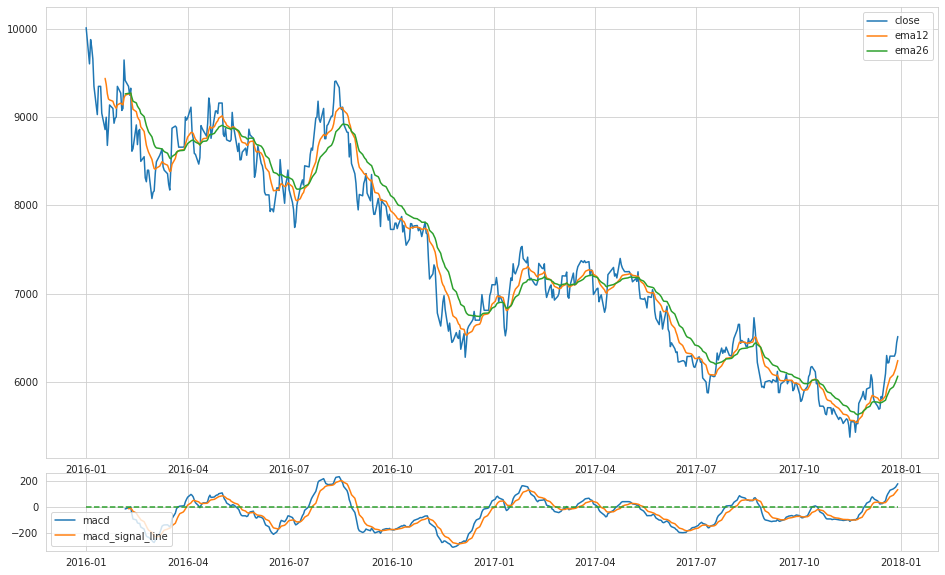

In [133]:
fig = plt.figure(figsize = (16, 10))
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)

ax1.plot(whl.index, whl['close'])
ax1.plot(whl.index, whl['ema12'])
ax1.plot(whl.index, whl['ema26'])
ax1.legend(('close', 'ema12', 'ema26', ))
ax1.set_xticklabels(' ')

ax2.plot(whl.index, whl['macd'])
ax2.plot(whl.index, whl['macd_signal_line'])
ax2.plot(whl.index, list(itertools.repeat(0, len(whl.index))), linestyle = 'dashed')
ax2.legend(('macd', 'macd_signal_line', ), loc = 'lower left')

In [96]:
%time
macd_data = pd.DataFrame()
for i, (symbol, data) in enumerate(trainPrices.items()):
    if len(data) > 100:
        data = data.copy()
        norm_close = data['close']#.div(data['close'][0])
        
        ema26 = ta.ema(norm_close, length = 26)
        ema12 = ta.ema(norm_close, length = 12)
        macd = ema12.sub(ema26)
        macd_ema9 = ta.ema(macd, length = 9)
        macd_signal = macd_ema9.sub(macd)

        macd_signal.name = 'macd_signal'
        out = pd.DataFrame(macd_signal)
        out['symbol'] = symbol
        out = out.reset_index().set_index(['Date', 'symbol'])

        macd_data = pd.concat([macd_data, out])
        # print(i, symbol)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


In [97]:
macd_data

macd_signal
Date       symbol              
2016-01-01 ABG.JO           NaN
2016-01-04 ABG.JO           NaN
2016-01-05 ABG.JO           NaN
2016-01-06 ABG.JO           NaN
2016-01-07 ABG.JO           NaN
...                         ...
2017-12-25 ZPLP.JO   -53.718039
2017-12-26 ZPLP.JO   -47.688752
2017-12-27 ZPLP.JO   -40.354182
2017-12-28 ZPLP.JO   -32.111094
2017-12-29 ZPLP.JO   -23.848948

[165329 rows x 1 columns]

In [98]:
prices_data = pd.DataFrame()
for symbol, data in trainPrices.items():
    out = data['close']
    out.name = symbol
    prices_data = pd.concat([prices_data, out], axis = 1)

In [99]:
prices_data

4SI.JO   ABG.JO  ABSP.JO  ACE.JO  ACG.JO  ACL.JO  ACS.JO  ACT.JO  \
2016-01-01     NaN  14349.0  70300.0    63.0  1740.0   450.0   950.0   540.0   
2016-01-04     NaN  13600.0  70300.0    63.0  1730.0   425.0   950.0   540.0   
2016-01-05     NaN  13816.0  69550.0    63.0  1730.0   425.0   950.0   530.0   
2016-01-06     NaN  13560.0  69500.0    63.0  1710.0   410.0   950.0   520.0   
2016-01-07     NaN  13000.0  69000.0    63.0  1675.0   451.0   900.0   515.0   
...            ...      ...      ...     ...     ...     ...     ...     ...   
2017-12-25   179.0  17200.0  68800.0    67.0   399.0   389.0   850.0   621.0   
2017-12-26   179.0  17200.0  68800.0    67.0   399.0   389.0   850.0   621.0   
2017-12-27   180.0  17685.0  68800.0    67.0   380.0   400.0   850.0   650.0   
2017-12-28   180.0  17800.0  68800.0    67.0   384.0   400.0   850.0   640.0   
2017-12-29   170.0  18106.0  68456.0    67.0   398.0   392.0   850.0   640.0   

             ACZ.JO  ADH.JO  ...  WEA.JO  WEZ.JO   WHL.JO  WKF.JO  WSL.JO  \
2016-01-01      NaN  1456.0  ...     NaN     NaN  10015.0     NaN    98.0   
2016-01-04      NaN  1453.0  ...    0.07     NaN   9605.0     NaN   105.0   
2016-01-05      NaN  1465.0  ...    0.07     NaN   9880.0     NaN   100.0   
2016-01-06      NaN  1463.0  ...    0.07     NaN   9788.0     NaN   100.0   
2016-01-07      NaN  1470.0  ...    0.07     NaN   9660.0     NaN    95.0   
...             ...     ...  ...     ...     ...      ...     ...     ...   
2017-12-25  9.26888  1675.0  ...     NaN     NaN   6293.0     NaN   165.0   
2017-12-26  9.26888  1675.0  ...    0.06     NaN   6293.0     NaN   165.0   
2017-12-27  9.26888  1635.0  ...    0.07     NaN   6329.0     NaN   166.0   
2017-12-28  9.26888  1639.0  ...    0.08     NaN   6447.0     NaN   166.0   
2017-12-29  9.26888  1691.0  ...    0.08     NaN   6515.0     NaN   167.0   

            YRK.JO  YYLBEE.JO  ZCL.JO  ZED.JO  ZPLP.JO  
2016-01-01   219.0        NaN     NaN   603.0   3900.0  
2016-01-04   222.0        NaN     NaN   584.0   3900.0  
2016-01-05   222.0        NaN     NaN   571.0   3900.0  
2016-01-06   215.0        NaN     NaN   554.0   4000.0  
2016-01-07   215.0        NaN     NaN   520.0   4000.0  
...            ...        ...     ...     ...      ...  
2017-12-25   270.0     6870.0   310.0   671.0   6395.0  
2017-12-26   270.0     6870.0   310.0   671.0   6395.0  
2017-12-27   268.0     6870.0   320.0   679.0   6393.0  
2017-12-28   259.0     6870.0   320.0   667.0   6385.0  
2017-12-29   258.0     6875.0   320.0   690.0   6380.0  

[520 rows x 431 columns]

In [100]:
prices_data.index = pd.to_datetime(prices_data.index)

In [120]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(
    factor = macd_data,
    prices = prices_data,
    quantiles = 3,
    periods = [1, 2, 5, 10, 30,]
)

Dropped 23.6% entries from factor data: 23.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [121]:
factor_data

1D        2D        5D       10D       30D  \
date       asset                                                       
2016-02-08 ABG.JO  -0.025883  0.004604  0.095019  0.071578  0.046463   
2016-02-09 ABG.JO   0.031297  0.007233  0.081501  0.056793  0.059944   
2016-02-10 ABG.JO  -0.023333  0.017361  0.048264  0.013889  0.005208   
2016-02-11 ABG.JO   0.041667  0.116041  0.119454  0.051337  0.009670   
2016-02-12 ABG.JO   0.071399  0.030785  0.033311 -0.011399 -0.030717   
...                      ...       ...       ...       ...       ...   
2017-08-21 ZPLP.JO  0.000000  0.009174  0.000183  0.009174  0.055046   
2017-08-22 ZPLP.JO  0.009174  0.000367  0.027523  0.018349  0.064220   
2017-08-23 ZPLP.JO -0.008727 -0.008909  0.018182  0.018182  0.036364   
2017-08-24 ZPLP.JO -0.000183 -0.000183  0.027146  0.017975  0.063830   
2017-08-25 ZPLP.JO  0.000000  0.027334  0.027334  0.018162  0.054852   

                         60D       90D     factor  factor_quantile  
date       asset                                                    
2016-02-08 ABG.JO   0.006697  0.010883 -10.213436                1  
2016-02-09 ABG.JO  -0.005944  0.025066  11.555064                3  
2016-02-10 ABG.JO  -0.064444 -0.002778   0.637074                2  
2016-02-11 ABG.JO  -0.064278  0.021047  19.133765                3  
2016-02-12 ABG.JO  -0.088737 -0.003208  -3.786114                1  
...                      ...       ...        ...              ...  
2017-08-21 ZPLP.JO  0.073394  0.173394  17.704965                3  
2017-08-22 ZPLP.JO  0.063670  0.173394  18.182791                3  
2017-08-23 ZPLP.JO  0.047091  0.162364  14.501532                3  
2017-08-24 ZPLP.JO  0.082172  0.171130  14.627496                3  
2017-08-25 ZPLP.JO  0.082370  0.170427  14.100382                3  

[126375 rows x 9 columns]

In [122]:
factor_data.groupby('factor_quantile').mean()

1D        2D        5D       10D       30D       60D  \
factor_quantile                                                               
1               -0.001039 -0.001291 -0.000879 -0.000174  0.001210  0.004051   
2                0.001073  0.001978  0.003923  0.004885  0.008565  0.018025   
3                0.004789  0.006179  0.008267  0.010789  0.016318  0.018865   

                      90D     factor  
factor_quantile                       
1                0.008246 -39.250031  
2                0.021209  -0.033011  
3                0.020913  45.273315

Information Analysis


1D     2D      5D     10D     30D     60D     90D
IC Mean           0.042  0.059   0.065   0.061   0.069   0.046   0.037
IC Std.           0.152  0.152   0.148   0.141   0.134   0.130   0.132
Risk-Adjusted IC  0.276  0.391   0.442   0.434   0.510   0.354   0.284
t-stat(IC)          NaN    NaN   8.880   8.722  10.257   7.123   5.699
p-value(IC)         NaN    NaN   0.000   0.000   0.000   0.000   0.000
IC Skew             NaN    NaN   1.725   0.484   2.293  -1.341  -1.356
IC Kurtosis         NaN    NaN  10.904  16.073  15.249  25.993  23.725

<Figure size 432x288 with 0 Axes>

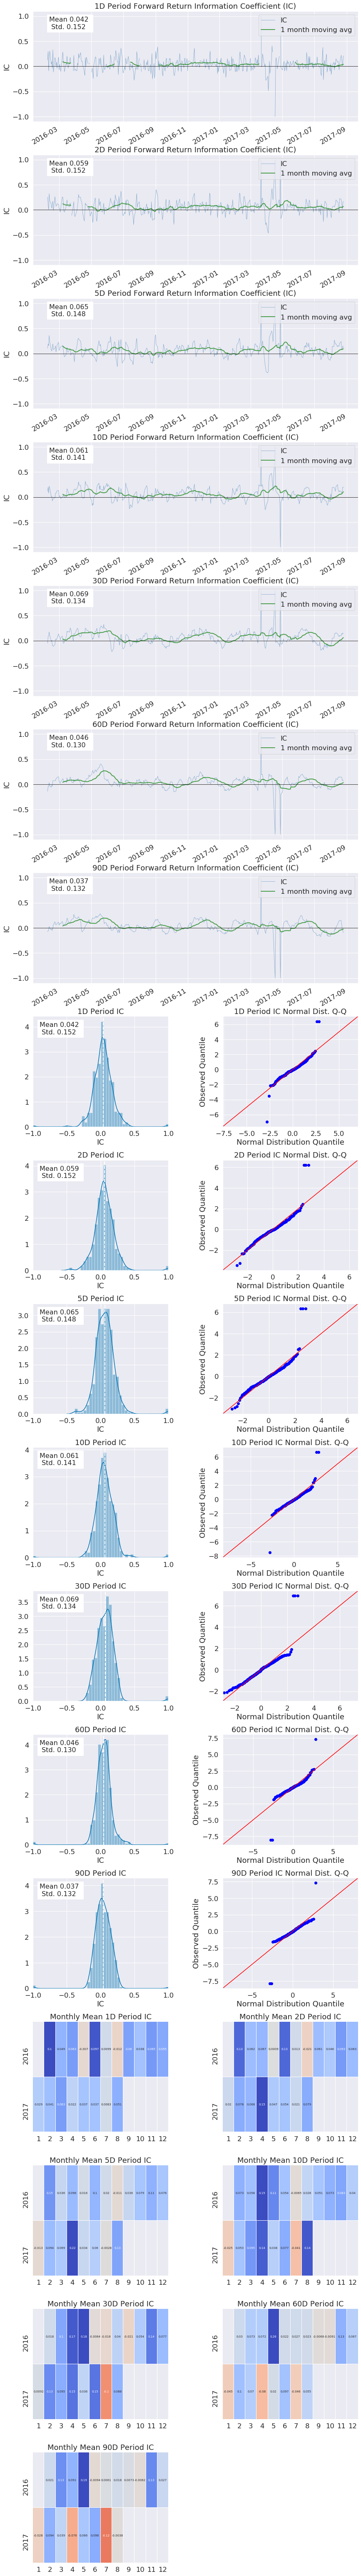

In [123]:
alphalens.tears.create_information_tear_sheet(factor_data)

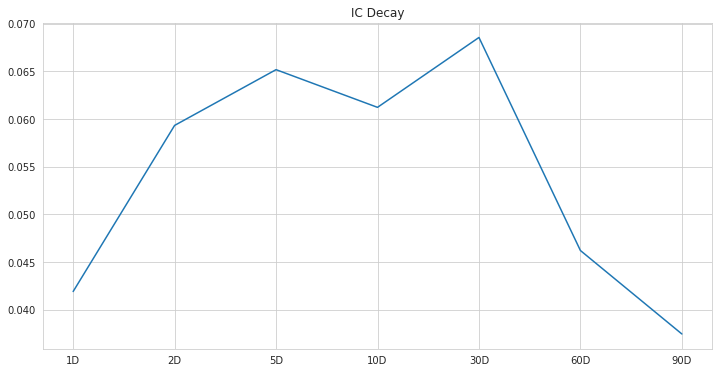

In [124]:
fig = plt.figure(figsize = (12, 6))
g = mean_information_coefficient(factor_data).plot(title = "IC Decay")

Returns Analysis


1D      2D      5D     10D  \
Ann. alpha                                      0.436   0.367   0.128   0.064   
beta                                            0.703   0.449   0.383   0.328   
Mean Period Wise Return Top Quantile (bps)     34.357  22.110  10.906   6.320   
Mean Period Wise Return Bottom Quantile (bps) -29.290 -20.598 -11.207  -6.039   
Mean Period Wise Spread (bps)                  63.647  42.143  21.819  12.195   

                                                 30D    60D    90D  
Ann. alpha                                     0.067  0.018  0.006  
beta                                          -0.155  0.057  0.045  
Mean Period Wise Return Top Quantile (bps)     2.619  0.890  0.454  
Mean Period Wise Return Bottom Quantile (bps) -2.598 -1.633 -0.966  
Mean Period Wise Spread (bps)                  5.192  2.521  1.424

<Figure size 432x288 with 0 Axes>

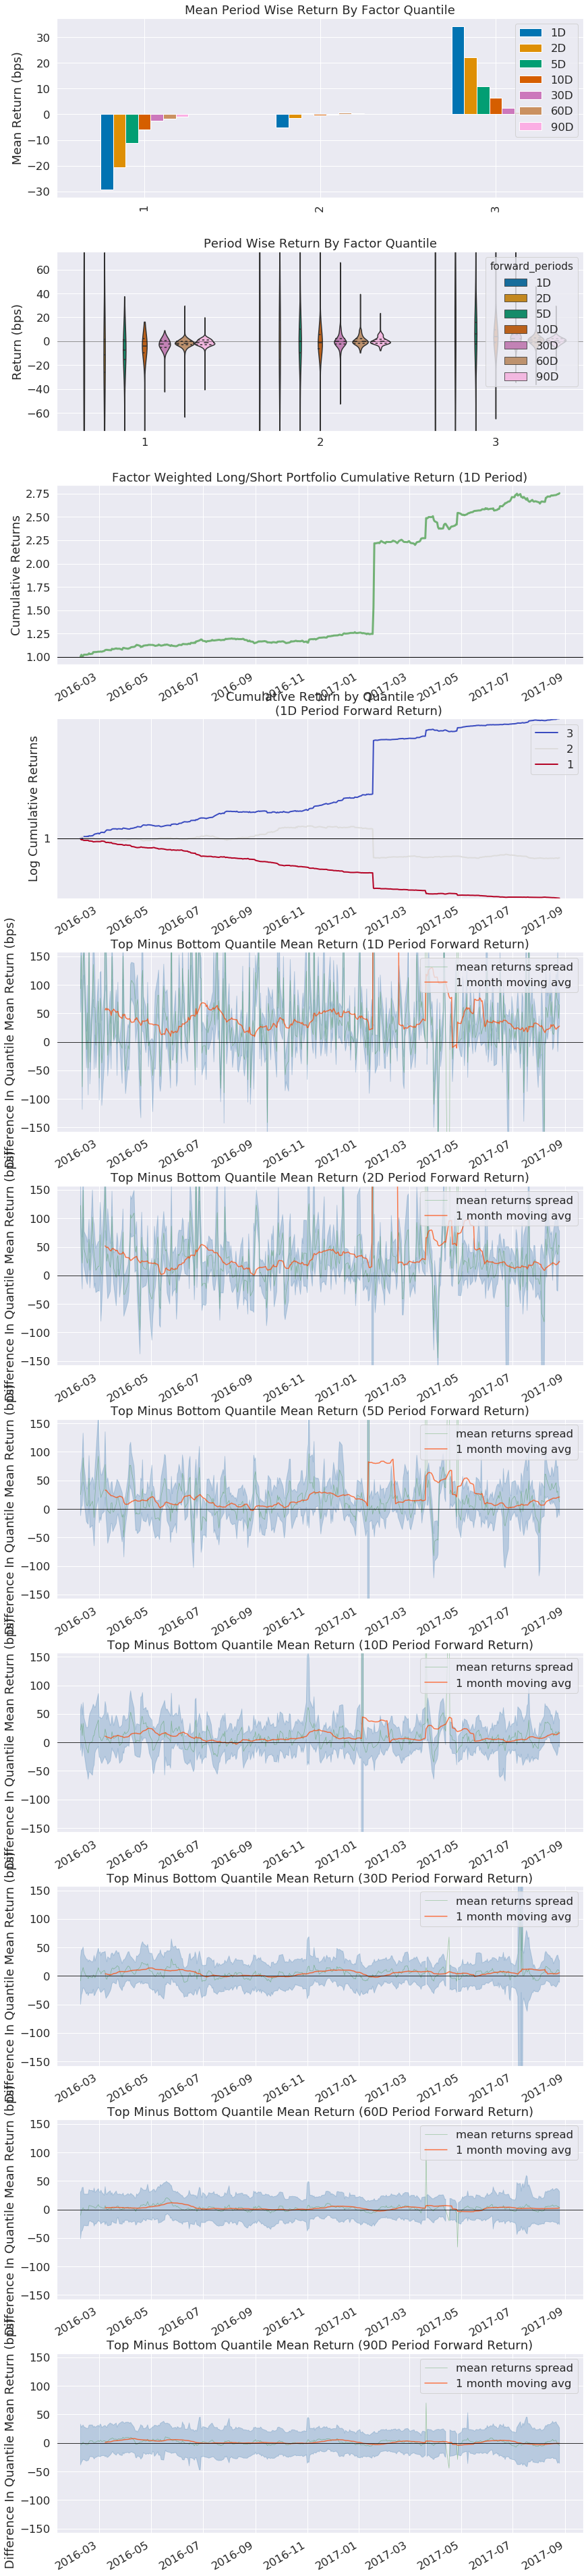

In [134]:
alphalens.tears.create_returns_tear_sheet(factor_data)